In [23]:
%load_ext autoreload
%autoreload 2
from MVC_env import MVC_environement
from DQN_network import embedding_network
import numpy as np
import networkx as nx
import math
import torch
from tqdm import tqdm_notebook as tqdm
import pickle
from heapdict import heapdict
from networkx.algorithms.approximation import min_weighted_vertex_cover
import random
import itertools
import warnings
warnings.filterwarnings("ignore")
def pickle_save(data,file_name):
    with open(file_name,'wb') as f:
        pickle.dump(data , f)
def pickle_load(file_name):
    with open(file_name,'rb') as f:
        return pickle.load(f)


np.random.seed(19960214)
random.seed(19960214)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [234]:
def is_vertex_cover(graph , cover):
    cover_edge = 0
    total_edge = len(graph.edges())
    checked_set = set()
    for c in cover:
        checked_set.add(c)
        for u in list(graph.neighbors(c)):
            if u not in checked_set:
                cover_edge += 1
            
    return cover_edge == total_edge

def mvc_bb(graph , UB = None , C = None):
    
    def DegLB():
    
        degree_list = nx.degree(graph)
        hd = heapdict()
        for v , d in degree_list:
            hd[v] = -d
        
        num_edge = len(graph.edges())
        count_edge = 0
        lb = 0
        select_nodes = []
        while count_edge < num_edge:
            cur_v , cur_degree = hd.popitem()
            count_edge += -(cur_degree)
            select_nodes.append(cur_v)
            for u in graph.neighbors(cur_v):
                if u in select_nodes:
                    continue
                hd[u] += 1
        cur_v , cur_degree = hd.popitem()
        graph_plum = graph.copy()
        graph_plum.remove_nodes_from(select_nodes)
        E_plum = len(graph_plum.edges())
        if cur_degree > 0:
            E_plum /= cur_degree
            
        return math.floor( len(select_nodes) + E_plum )
    
    if len(graph.edges()) == 0:
        #return len(C)
        return C
    #LB = DegLB()
    LB = 0
    if len(C) + LB >= UB:
        #return UB
        return [i for i in range(UB+1)]
    
    degree_list = nx.degree(graph)
    v , d = max(degree_list , key = lambda a : a[1])
    
    C1 = C[:]
    C2 = C[:]
    graph_1 = graph.copy()
    C1.extend(list(graph.neighbors(v)))
    #C1.append(v)
    graph_1.remove_nodes_from(C1)
    C1= mvc_bb(graph_1 , UB , C1)

    C2.append(v)
    graph_2 = graph.copy()
    graph_2.remove_node(v)
    C2 = mvc_bb(graph_2 , min(UB , len(C1)) , C2 )

    if len(C1)>len(C2):
        return C2
    else:
        return C1


In [241]:
opt_results_old = opt_results[:]

In [239]:
opt_results_new = []
for i in range(N):
    
    cur_res = []
    
    for j in tqdm(range(VALIDATION_GRAPH_NUM)):
        cur_g = all_graphs[i][j]
        #print(nx.density(cur_g))
        C = mvc_bb(cur_g , len(cur_g.nodes()) , [])
        cur_res.append(len(C))
    print(sum(cur_res) , len(cur_res) , sum(cur_res)/len(cur_res))
    opt_results_new.append(sum(cur_res)/len(cur_res))

16246 500 32.492


19292 500 38.584


21273 500 42.546


22444 500 44.888


22917 500 45.834


14505 500 29.01


17515 500 35.03


18291 500 36.582


15999 500 31.998


15000 500 30.0


In [228]:
validation(dqn , all_graphs[0][:])

33.122

In [236]:
33.122/32.492

1.0193893881570848

In [70]:
for i in range(1):
    g = nx.erdos_renyi_graph(n = 50 , p = 0.15)
    env = MVC_environement(g)
    
    sol = mvc_bb(g , len(g.nodes()) , [])
    done = False
    idx = 0
    while done == False:
        action = sol[idx]
        idx += 1
        _ , _ , done = env.take_action(action)

In [4]:
import numpy as np
from collections import namedtuple

experience = namedtuple("experience" , ['graph','Xv','action','reward','next_Xv','is_done'])

class replay_buffer():
    def __init__(self , max_size):
        self.buffer = np.zeros(  [max_size],dtype = experience)
        self.max_size = max_size
        self.size = 0
        self.idx = -1
    def push(self , new_exp):
        if(self.size >= self.max_size):
            self.idx = (self.idx+1) % self.max_size
        else:
            self.idx = self.idx + 1
            self.size += 1
        
        self.buffer[self.idx] = new_exp
    
    def sample(self , batch_size):
        batch = np.random.choice(np.arange(self.size) , size = batch_size , replace=False)
        
        return self.buffer[[batch]]
    


In [6]:
def approximate_algo(env):
    edge_list = env.edges[:]
    
    C =  set()
    #print(len(edge_list))
    while( len(edge_list) > 0):
        #print(len(edge_list))
        e = edge_list[-1]
        u,v = e
        C.add(u)
        C.add(v)
        to_remove = []
        for ed in edge_list:
            if (u in ed) or (v in ed):
                to_remove.append(ed)
        for ed in to_remove:
            edge_list.remove(ed)
    
    for v in C:
        env.take_action(v)
    
    return C



In [227]:
def validation(dqn , validation_graph , device = 'cuda:0'):
    objective_vals = []
    for g in validation_graph:
        env = MVC_environement(g)
        Xv , graph = env.reset_env()
        graph = torch.unsqueeze(graph,  0)
        Xv = Xv.clone()
        Xv = Xv.cuda()
        graph = graph.to(device)
        done = False
        non_selected = list(np.arange(env.num_nodes))
        selected = []
        while done == False:
            #Xv = Xv.cuda()
            Xv = Xv.to(device)
            val = dqn(graph , Xv)[0]
            val[selected] = -float('inf')
            action = int(torch.argmax(val).item())
            Xv_next , reward , done = env.take_action(action)
            non_selected.remove(action)
            selected.append(action)
            Xv = Xv_next
        #print(selected)
        objective_vals.append(len(selected))
    return sum(objective_vals)/len(objective_vals)

In [271]:
def training_validation( validation_a , validation_bs , validation_per_epoch = 30 , num_validation = 20  ,
                        type_train = 'er', graph_size = 50 , device = 'cuda:1' , 
                        density = 0.1 , opt_train = -1 , opt_val=[] , imitation = False):
    
    torch.cuda.manual_seed_all(19960214) # for reproduce
    torch.manual_seed(19960214) # for reproduce
    np.random.seed(19960214)
    random.seed(19960214)
    MAX_EPISODE = validation_per_epoch * num_validation + 1
    dqn = embedding_network(emb_dim=64 , T = 5 , device=device , init_factor = 10 , w_scale = 0.01).double()
    target_net = embedding_network(emb_dim=64 , T = 5,device=device , init_factor = 10 , w_scale = 0.01).double()
    target_net.load_state_dict(dqn.state_dict())
    EPS_START = 1.00
    EPS_END = 0.05
    EPS_DECAY = 10000
    steps_done = 0
    loss_func = torch.nn.MSELoss()
    USE_CUDA = torch.cuda.is_available()
    N_STEP = 2
    reward_history = []
    batch_size = 64
    buffer = replay_buffer(500000)
    optimizer = torch.optim.Adam(dqn.parameters(),lr=0.0001 , amsgrad=False)
    #optimizer = torch.optim.RMSprop(dqn.parameters(), lr = 0.0001)
    validation_result = []
    another_result = [[] for _ in range(len(validation_bs))]
    reward_history = []
    res = []
    if opt_train == -1:
        for g in validation_a:
            #env = MVC_environement(g)
            #C = approximate_algo(env)
            #C = min_weighted_vertex_cover(g)
            C = mvc_bb(g , len(g.nodes()) , [])
            res.append(len(C))
        approx_val = sum(res)/len(res)
    else:
        approx_val = opt_train
        
    approx_val_anothers = []
    if len(opt_val) == 0:
        for validation_b in validation_bs:
            res = []
            for g in validation_b:
                #env = MVC_environement(g)
                #C = approximate_algo(env)
                #C = min_weighted_vertex_cover(g)
                C = mvc_bb(g , len(g.nodes()) , [])
                res.append(len(C))
            approx_val_another = sum(res)/len(res)
            approx_val_anothers.append(approx_val_another)
    else:
        approx_val_anothers = opt_val[:]

    if USE_CUDA:
        #dqn = dqn.cuda()
        #target_net = target_net.cuda()
        dqn.to(device)
        target_net.to(device)
    fitted_q_exp = namedtuple("fitted_exp" , ['graph','Xv','action','reward'])
    
    #print('density',nx.density(validation_a[0]),nx.density(validation_b[0]))
    print('value',approx_val,end=' ' )
    for va in approx_val_anothers:
        print(va,end=' ')
    print('')
    for e in tqdm(range(MAX_EPISODE)):
        def density_to_edge_ba(n , p):
            return math.ceil( p *n  /2)
        #p = np.random.uniform(0.05,0.3)
        if type_train == 'er':
            g = nx.erdos_renyi_graph(n = graph_size , p = density)
        elif type_train == 'ba':
            ba_m = density_to_edge_ba(graph_size , density)
            g = g = nx.barabasi_albert_graph(graph_size , ba_m)
        else:
            raise 'Not Implemented'
        
        #if e % 2 == 0:
        #    imitation = False
        #else:
        #    imitation = True
        
        if imitation:
            opt_sol = mvc_bb(g , len(g.nodes()) , [])
            idx = 0
        env = MVC_environement(g)
        
        Xv , graph = env.reset_env()
        Xv = Xv.clone()
        graph = torch.unsqueeze(graph,  0)
        done = False
        
        non_selected = list(np.arange(env.num_nodes))
        selected = []
        eps_reward = []
        
        if USE_CUDA:
            graph = graph.to(device)
            Xv = Xv.to(device)
        N = 0
        reward_list = []
        fitted_experience_list = []
        cur_episode_loss = []
        
        
        idx = 0
        
        while done == False:
            eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)

            if USE_CUDA:
                #Xv = Xv.cuda()
                Xv = Xv.to(device)
            
            if imitation:
                #print(len(opt_sol) , idx , done)
                action = opt_sol[idx]
                #print(action)
                idx += 1
            else:
                if np.random.uniform() > eps_threshold:
                    val = dqn(graph , Xv)[0]
                    #print(val)
                    #break
                    val[selected] = -float('inf')
                    action = int(torch.argmax(val).item())
                else:
                    action = int(np.random.choice(non_selected))
            
            Xv_next , reward , done = env.take_action(action)
            #print('total',len(env.edges) , 'cover' , env.covered_edges)
            
            eps_reward.append(reward)
            Xv_next = Xv_next.clone()
            fit_ex = fitted_q_exp(graph , Xv , action , reward)
            fitted_experience_list.append(fit_ex)
            
            non_selected.remove(action)
            selected.append(action)
            N += 1 
            reward_list.append(reward)
            if N >= N_STEP:
                n_reward = sum(reward_list)
                #reward_n = reward
                n_prev_ex = fitted_experience_list[0]
                n_graph = n_prev_ex.graph
                n_Xv = n_prev_ex.Xv
                n_action = n_prev_ex.action
                #ex = experience(graph , Xv , torch.tensor([action]) , torch.tensor([reward_n]) , Xv_next , done)
                #print(sum(n_Xv[0]),sum( Xv_next[0]))
                ex = experience(n_graph , n_Xv , torch.tensor([n_action]) , torch.tensor([n_reward]) , Xv_next , done)
                buffer.push(ex)
                fitted_experience_list.pop(0)
                reward_list.pop(0)
            Xv = Xv_next
            
            steps_done += 1

            if buffer.size >= batch_size:
                batch = buffer.sample(batch_size)
                batch = experience(*zip(*batch))
                batch_graph = torch.cat(batch.graph)
                batch_state = torch.cat(batch.Xv)
                batch_action = torch.cat(batch.action)
                batch_reward = torch.cat(batch.reward).double()
                batch_next_state = torch.cat(batch.next_Xv)
                non_final_mask = torch.tensor(tuple(map(lambda s : s is not True, batch.is_done)),dtype = torch.uint8)

                non_final_graph = batch_graph[non_final_mask]
                non_final_next_state = batch_next_state[non_final_mask]

                next_state_value = torch.zeros(batch_size).detach().double()
                if USE_CUDA:
                    batch_graph = batch_graph.to(device)
                    batch_state = batch_state.to(device)
                    batch_action = batch_action.to(device)
                    batch_reward = batch_reward.to(device)
                    batch_next_state = batch_next_state.to(device)
                    next_state_value = next_state_value.to(device)
                    non_final_graph = non_final_graph.to(device)
                    non_final_next_state = non_final_next_state.to(device)

                pred_q = dqn(batch_graph , batch_state ).gather(1 , batch_action.view(-1,1)).view(-1)

                
                next_state_value[non_final_mask] = target_net(non_final_graph , non_final_next_state).max(1)[0].detach()
                expected_q = next_state_value + batch_reward
                loss = loss_func(pred_q , expected_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                cur_episode_loss.append(loss.item())
        #if len(cur_episode_loss) and e % 10 == 0:
        #    print(sum(cur_episode_loss)/len(cur_episode_loss) , eps_threshold)
        if e > 0 and e % 8 == 0:
            target_net.load_state_dict(dqn.state_dict())
            
        if e > 0 and e % validation_per_epoch == 0:
            v = validation(dqn , validation_a , device=device)
            validation_result.append(v / approx_val)
            for i , validation_b in enumerate(validation_bs):
                v = validation(dqn , validation_b , device=device)
                another_result[i].append(v / approx_val_anothers[i])
        reward_history.append(sum(eps_reward))
    return validation_result , another_result  , reward_history , dqn

In [162]:
def density_to_edge_ba(n , p):
    return math.ceil( p *n  /2)
def validation_graph_gen(n , p , num = 100, graph_type = 'er'):
    np.random.seed(19960214)
    random.seed(19960214)
    validation_graph = []
    for i in range(num):
        if graph_type == 'er':
            g = nx.erdos_renyi_graph(n , p)
            validation_graph.append(g)
        elif graph_type == 'ba':
            m = density_to_edge_ba(n , p)
            g = nx.barabasi_albert_graph(n , m)
            validation_graph.append(g)
            
    return validation_graph

def test_with_paras( graph_size , graph_type_a , density_a , graph_type_b , density_b):
    val_a = validation_graph_gen(n = graph_size , p = density_a  , graph_type = graph_type_a)
    val_b = validation_graph_gen(n = graph_size , p = density_b  , graph_type = graph_type_b)
    ba_m = density_to_edge_ba(graph_size , density_a)
    result_a , result_b , _ = training_validation(val_a , val_b , num_validation=25 , validation_per_epoch=10 , 
                                                 type_train = graph_type_a , graph_size = graph_size,
                                                 er_p = density_a , ba_m = ba_m)
    return result_a , result_b

In [ ]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
graph_size_list = [50]
graph_type_list = ['er' , 'ba']
density_list = [0.15,0.3,0.5,0.7,0.8]

parameter_list = list(itertools.product(graph_size_list , graph_type_list ,density_list))
N = len(parameter_list)
VALIDATION_GRAPH_NUM = 500
'''
performance_dict = {}
all_graphs = []
opt_results = []
for i in range(N):
    train_size = parameter_list[i][0]
    train_type = parameter_list[i][1]
    train_density = parameter_list[i][2]
    
    train_graphs = validation_graph_gen(n = train_size , p = train_density 
                                        , num = VALIDATION_GRAPH_NUM , graph_type=train_type)
    
    all_graphs.append(train_graphs)

for i in range(N):
    
    cur_res = []
    
    for j in tqdm(range(VALIDATION_GRAPH_NUM)):
        cur_g = all_graphs[i][j]
        C = mvc_bb(cur_g , len(cur_g.nodes()) , [])
        cur_res.append(len(C))
    opt_results.append(sum(cur_res)/len(cur_res))
'''

print(opt_results)
for i in range(1,N):
    train_size = parameter_list[i][0]
    train_type = parameter_list[i][1]
    train_density = parameter_list[i][2]
    legend_word = ['{}_{}'.format(train_type,train_density)]
    opt_train = opt_results[i]
    train_graphs = all_graphs[i][:]
    opt_vals = []
    validation_anothers = []
    print('training ',parameter_list[i])
    for j in range(N):
        
        if i == j:
            continue
        val_size = parameter_list[j][0]
        val_type = parameter_list[j][1]
        val_density = parameter_list[j][2]
        
        validation_anothers.append(all_graphs[j][:])
        opt_vals.append(opt_results[j])
        legend_word.append('{}_{}'.format(val_type,val_density))
    validation_result , another_result  , reward_history , dqn = training_validation(train_graphs , validation_anothers,
                                                                              num_validation=250 , validation_per_epoch=30,
                                                                              type_train= train_type , graph_size=train_size
                                                                              ,density = train_density , 
                                                                                    opt_train=opt_train,
                                                                              opt_val = opt_vals, device='cuda:0',
                                                                                    imitation=False)
    plt.plot(validation_result)
    performance_dict[legend_word[0]] = {legend_word[0]:validation_result}
    for v , l in zip(another_result , legend_word[1:]):
        plt.plot(v)
        performance_dict[legend_word[0]][l] = v
    plt.legend(legend_word)
    plt.show()
    


[32.492, 38.584, 42.546, 44.888, 45.834, 29.01, 35.03, 36.582, 31.998, 30.0]
training  (50, 'er', 0.3)
value 38.584 32.492 42.546 44.888 45.834 29.01 35.03 36.582 31.998 30.0 


In [151]:
#pickle_save(performance_dict , 'validation_result/performance_dict_0224_15_70.pkl')

In [266]:
opt_results_new,opt_results_old

([32.492, 38.584, 42.546, 44.888, 45.834, 29.01, 35.03, 36.582, 31.998, 30.0],
 [34.41, 40.494, 44.102, 46.036, 46.834, 30.216, 36.558, 37.91, 32.07, 30.0])

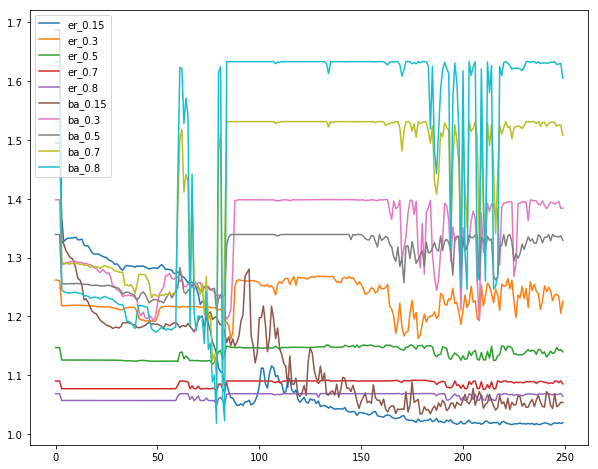

In [262]:
legend_w = []
plt.figure(figsize=(10,8))
for k , v in performance_dict['er_0.15'].items():
    legend_w.append(k)
    plt.plot(v)
    
plt.legend(legend_w)